# 06. Milestone Project 2 PyTorch Paper Replicating

## 0. Get setup

In [1]:
# # For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
# try:
#     import torch
#     import torchvision
#     assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
#     assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")
# except:
#     print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
#     !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#     import torch
#     import torchvision
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
print(torch.__version__)
print(torchvision.__version__)

2.8.0+cu126
0.23.0+cu126


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 44.56 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [4]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get Data

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [7]:
from going_modular.going_modular import data_setup
from torchvision import transforms

# data_setup.create_dataloaders()
IMG_SIZE = 224

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,

    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), len(class_names), class_names


(8, 3, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image, label

(tensor([[[0.0275, 0.0510, 0.0784,  ..., 0.6863, 0.6353, 0.5843],
          [0.0353, 0.0353, 0.0431,  ..., 0.4824, 0.5451, 0.5765],
          [0.0314, 0.0314, 0.0314,  ..., 0.2745, 0.4118, 0.5765],
          ...,
          [0.4314, 0.4510, 0.5882,  ..., 0.3882, 0.5490, 0.4902],
          [0.4235, 0.4471, 0.5098,  ..., 0.3686, 0.4431, 0.4667],
          [0.5412, 0.5020, 0.4980,  ..., 0.3725, 0.3490, 0.3451]],
 
         [[0.0118, 0.0353, 0.0667,  ..., 0.5647, 0.5961, 0.5686],
          [0.0196, 0.0196, 0.0314,  ..., 0.3608, 0.4863, 0.5216],
          [0.0157, 0.0157, 0.0196,  ..., 0.1725, 0.3216, 0.4745],
          ...,
          [0.1608, 0.1765, 0.3176,  ..., 0.1176, 0.2784, 0.2196],
          [0.1529, 0.1922, 0.2745,  ..., 0.1059, 0.1804, 0.2039],
          [0.2784, 0.2627, 0.2902,  ..., 0.1137, 0.0941, 0.0902]],
 
         [[0.0039, 0.0275, 0.0549,  ..., 0.4941, 0.4941, 0.4706],
          [0.0078, 0.0078, 0.0196,  ..., 0.2941, 0.3961, 0.4392],
          [0.0039, 0.0039, 0.0078,  ...,

In [10]:
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

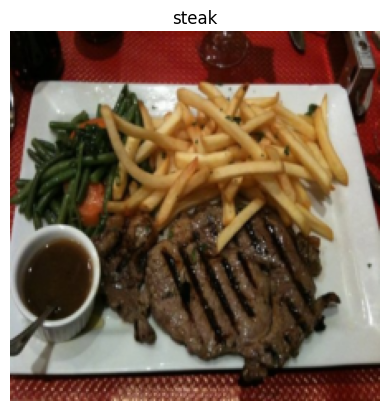

In [11]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))  # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating ViT Overview

* **Inputs**
* **Outputs**
* **Layers**
* **Bloacjs**
* **Model**

### 3.1 ViT Overview: pieces of the puzzle

* Figure 1 Visual overview of the architecture

* Four equation
* Table 1/3

* Embedding = learnable representation

### Figure 1

### Four Equation

### Table 1

### Section 3.1 describes the various equations

## 4. Equation 1: Split data into patches and creating class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224 3) -> single image -> [Height, width color channels]

* Output shape:

* Input shape: $H\times{W}\times{C}$ (height x width x color channels)

* Output shape: ${N \times\left(P^{2} \cdot C\right)}$

* H = height
* W = width
* C = color channels
* N = number of patches = (hegith * width) / p ^ 2
* D = constant latent vector size = embedding dimension (see table 1)

Output image: $\mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$

In [12]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16 # (16, 16, 3)

# Calculate the Number of patches
number_of_patches = int((height * width) / patch_size ** 2)
# Total patches = (224 / 16) × (224 / 16) = 14 × 14 = 196 patches
number_of_patches

196

In [13]:
# number of patches along height = 224 / 16 = 14
# number of patches along width  = 224 / 16 = 14

# total patches = 14 × 14 = 196
# N = 16

### 4.1 Calculate Input and Output shape by hand

In [14]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels) # P^2 * C = 16 * 16 * 3 = 768

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number of patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number of patches, embedding_dimension)


### 4.2 Turning a single image into patches

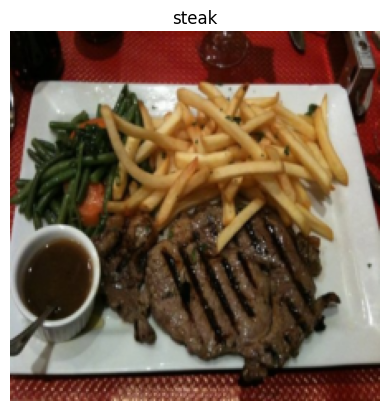

In [15]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [16]:
# image

In [17]:
image.shape

torch.Size([3, 224, 224])

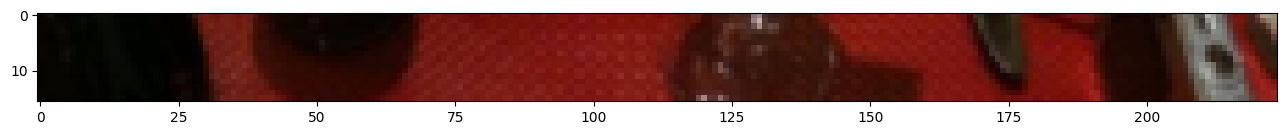

In [18]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # Convert image to color channels last[H, W, C]

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[: patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


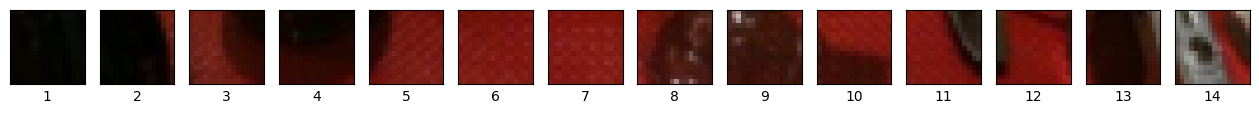

In [19]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

assert img_size % patch_size == 0, "Image size must be divisible by patch size"

fig, axs = plt.subplots(nrows=1,
                       ncols=img_size // patch_size,
                       sharex=True,
                       sharey=True,
                        figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
  # print(patch)
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch size: 16 pixels x 16 pixels


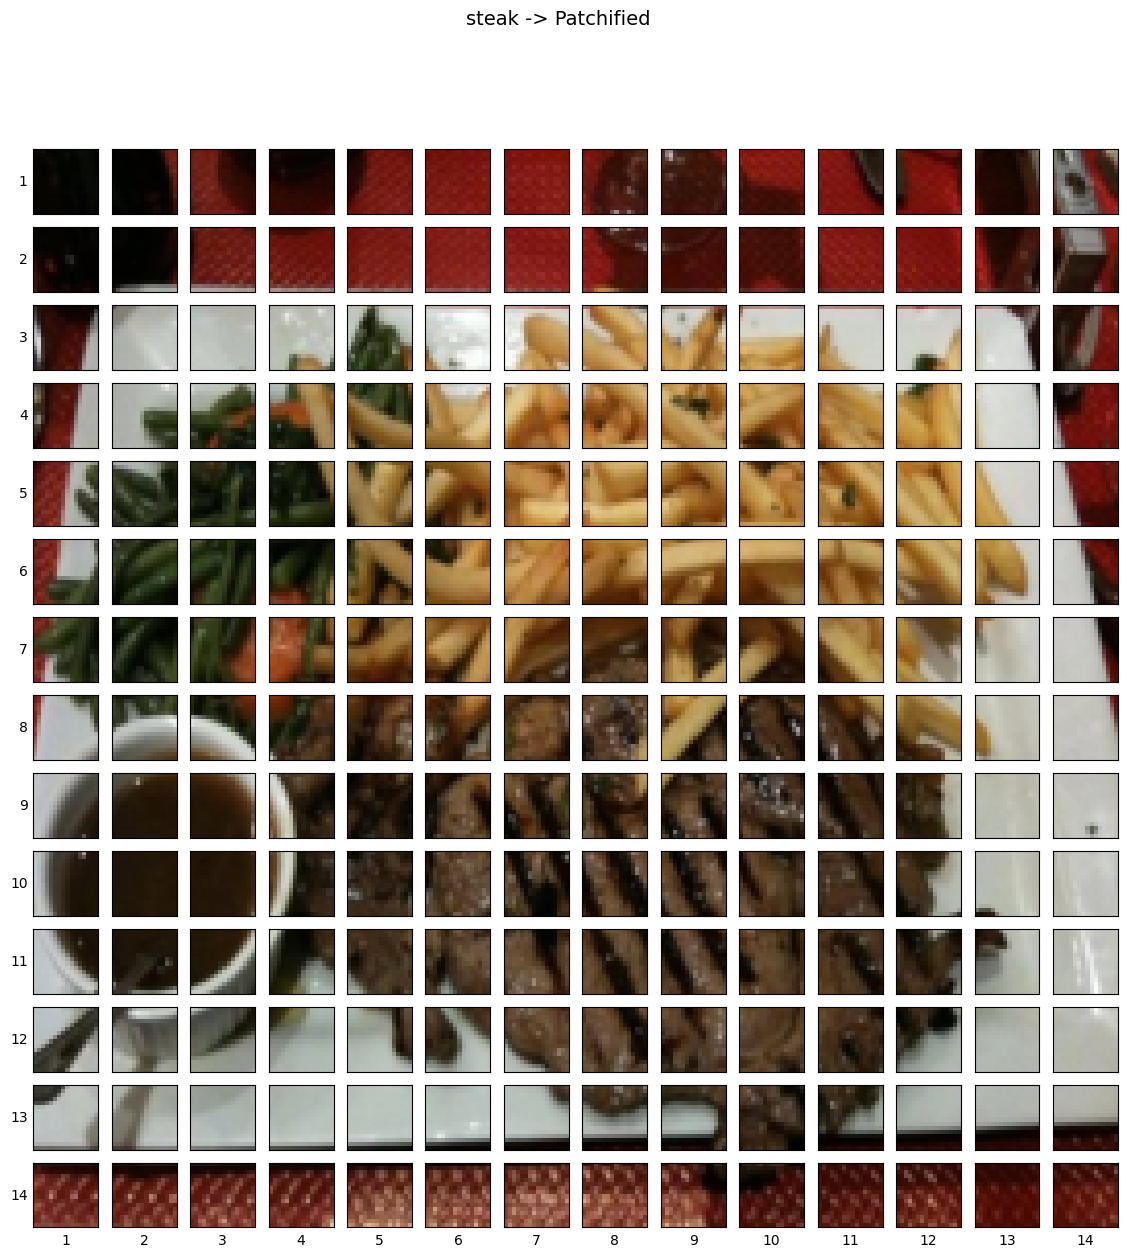

In [20]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
\nNumber of patches per column: {num_patches}\
\nTotal patches: {num_patches * num_patches}\
\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series aof subplots
fig, axs = plt.subplots(nrows = img_size // patch_size,
                        ncols = img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                    patch_width:patch_width+patch_size,
                                    :])

    axs[i, j].set_ylabel(i + 1,
                         rotation='horizontal',
                         horizontalalignment='right',
                         verticalalignment='center')
    # axs[i, j].set_xlabel(j + 1,
    #                      rotation='horizontal',
    #                      horizontalalignment='center',
    #                      verticalalignment='center')
    axs[i, j].set_xlabel(j + 1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()


In [21]:
14 * 14

196

### 4.3 Creating image patches and turning them into patch embeddings

In [22]:
# Create conv2d layer to turn image into patches of learnable featur maps (embeddings)

from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3, # For color images
                   out_channels=768, # D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0
                   )

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

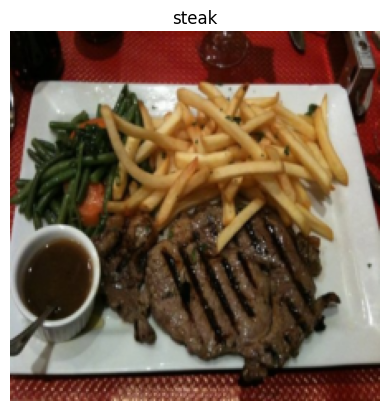

In [23]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [24]:
# Pass the image through convolution layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # Add batch dimension -> [batch_size, color_channels, height, width]
print(image_out_of_conv.shape)
# image_out_of_conv

torch.Size([1, 768, 14, 14])


In [25]:
14 * 14

196

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]

```

In [26]:
# image_out_of_conv

In [27]:
image_out_of_conv.requires_grad

True

In [28]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes: [480, 44, 725, 395, 148]


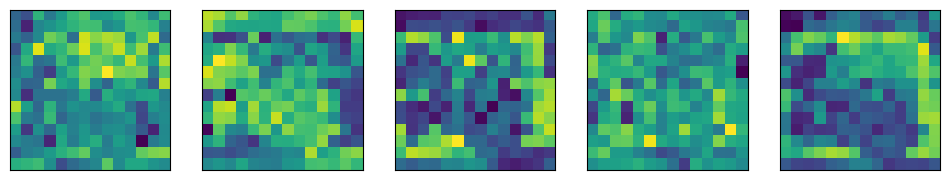

In [29]:
# Plot random convolutional feature maps (embeddings)

import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(12, 12))

for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]
  # axs[i].imshow(image_conv_feature_map.squeeze()) # remove batch dimension and remove from grad tracking / switch to numpy for matplotlib
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension and remove from grad tracking / switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [30]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.shape, single_feature_map.requires_grad

(tensor([[[-0.0382, -0.0179, -0.0652, -0.0500, -0.0675, -0.0344, -0.0249,
           -0.0734,  0.0502,  0.0149, -0.0663, -0.0639, -0.0565, -0.1292],
          [-0.0554, -0.0373, -0.0644, -0.0458, -0.0180, -0.0329, -0.0424,
           -0.0070, -0.0428, -0.0256, -0.0086, -0.0346,  0.0049,  0.0884],
          [-0.0884, -0.2572, -0.2509, -0.1607,  0.0904, -0.2044, -0.1277,
           -0.2011, -0.0033, -0.0744, -0.2257, -0.2239, -0.2965,  0.0211],
          [-0.1503,  0.0135, -0.0611,  0.0561, -0.2136, -0.0805,  0.0141,
           -0.0753, -0.2043,  0.0538, -0.1031, -0.1498, -0.1781, -0.0558],
          [-0.0226,  0.0157, -0.0459, -0.0823, -0.0339, -0.0057, -0.2431,
           -0.1225, -0.1419, -0.1294, -0.0906, -0.2250, -0.1030, -0.1092],
          [ 0.0362, -0.0673, -0.1059, -0.1267, -0.0593, -0.0640, -0.0368,
           -0.0398, -0.0204,  0.0070, -0.0670, -0.0126, -0.0857, -0.1418],
          [-0.1535, -0.0775, -0.1065, -0.1203,  0.0121, -0.0981,  0.0046,
           -0.0730, -0.1003, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

In [31]:
print(f"{image_out_of_conv.shape} -> [batch_size, embedding_dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]


In [32]:
14 * 14

196

In [33]:
[1, 768, 196]

[1, 768, 196]

Want : (batch_size, number_of_patches, embedding_dim)

In [34]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

# flatten_layer(image_out_of_conv)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape : torch.Size([3, 224, 224])
Image feature map (patches) shape : torch.Size([1, 768, 14, 14])
Flattened image feature map shape : torch.Size([1, 768, 196])


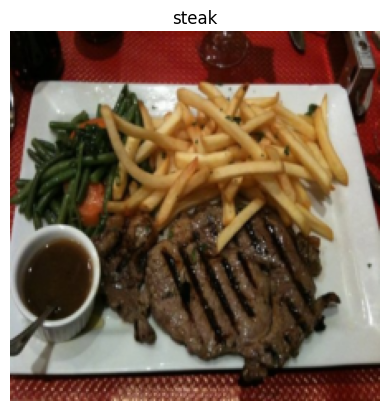

In [35]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape : {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape : {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape : {image_out_of_conv_flattened.shape}")

In [36]:
# Rearrange output of flattened layer
# print(f"{image_out_of_conv_flattened.permute(0, 2, 1).shape} -> [batch_size, number_of_patches, embedding_dimension]")

image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> [batch_size, number_of_patches, embedding_dimension]")

torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

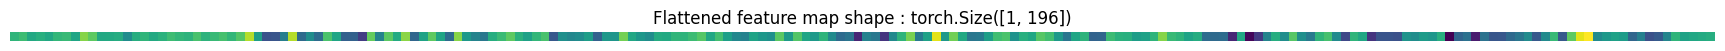

In [37]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattened_feature_map

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape : {single_flattened_feature_map.shape}")
plt.axis(False)

(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

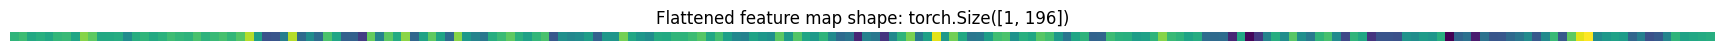

In [38]:
# Get feature dimension 0 across all patches
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot
plt.figure(figsize=(22, 2))
plt.imshow(single_flattened_feature_map.detach().numpy(), cmap='viridis')
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)


### 4.5 Turning the ViT patch embedding layer into a PyTorch module

In [39]:
from torch import nn

class PatchEmbedding(nn.Module):

  def __init__(self,
               in_channels: int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768):
    super().__init__()
    self.patch_size = patch_size

    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)


  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)


In [40]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output image size: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output image size: torch.Size([1, 196, 768])


In [41]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor)
# patchify(rand_image_tensor_bad)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

In [42]:
250 / 16

15.625

### 4.6 Creating the class token embedding

In [43]:
# patch_embedded_image
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [44]:
patch_embedded_image

tensor([[[-4.9274e-02, -1.2502e-04, -3.5572e-02,  ...,  1.1833e-02,
          -1.2263e-02,  2.4581e-02],
         [-6.7786e-02,  5.7727e-02, -5.2555e-02,  ...,  1.9184e-02,
          -7.7774e-02,  8.0018e-03],
         [-1.4700e-01, -5.3285e-02, -3.3463e-02,  ...,  2.2622e-02,
          -6.2656e-02,  2.1706e-01],
         ...,
         [-2.5101e-01, -4.8922e-02, -3.0782e-02,  ...,  2.0408e-01,
          -1.1166e-01,  1.8546e-01],
         [-1.9574e-01, -3.1517e-02, -2.3149e-02,  ...,  4.5486e-02,
          -1.0676e-01,  1.2881e-01],
         [-3.2620e-01, -6.5398e-03, -8.1226e-03,  ...,  1.0947e-01,
          -1.3815e-01,  1.0507e-01]]], grad_fn=<PermuteBackward0>)

In [45]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [46]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
requires_grad=True)
# class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),requires_grad=True)

# class_token
class_token.shape

torch.Size([1, 1, 768])

In [47]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [48]:
# Add the class token embedding to the fron of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1) # number_of_patches_dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequnece of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-4.9274e-02, -1.2502e-04, -3.5572e-02,  ...,  1.1833e-02,
          -1.2263e-02,  2.4581e-02],
         [-6.7786e-02,  5.7727e-02, -5.2555e-02,  ...,  1.9184e-02,
          -7.7774e-02,  8.0018e-03],
         ...,
         [-2.5101e-01, -4.8922e-02, -3.0782e-02,  ...,  2.0408e-01,
          -1.1166e-01,  1.8546e-01],
         [-1.9574e-01, -3.1517e-02, -2.3149e-02,  ...,  4.5486e-02,
          -1.0676e-01,  1.2881e-01],
         [-3.2620e-01, -6.5398e-03, -8.1226e-03,  ...,  1.0947e-01,
          -1.3815e-01,  1.0507e-01]]], grad_fn=<CatBackward0>)
Sequnece of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### 4.7 Creating the positioning embedding

In [49]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [-4.9274e-02, -1.2502e-04, -3.5572e-02,  ...,  1.1833e-02,
           -1.2263e-02,  2.4581e-02],
          [-6.7786e-02,  5.7727e-02, -5.2555e-02,  ...,  1.9184e-02,
           -7.7774e-02,  8.0018e-03],
          ...,
          [-2.5101e-01, -4.8922e-02, -3.0782e-02,  ...,  2.0408e-01,
           -1.1166e-01,  1.8546e-01],
          [-1.9574e-01, -3.1517e-02, -2.3149e-02,  ...,  4.5486e-02,
           -1.0676e-01,  1.2881e-01],
          [-3.2620e-01, -6.5398e-03, -8.1226e-03,  ...,  1.0947e-01,
           -1.3815e-01,  1.0507e-01]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [50]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size ** 2)
# number_of_patches

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
# embedding_dimension

position_embedding = nn.Parameter(torch.ones(1,
                                                number_of_patches + 1,
                                                embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [51]:
# Add the positioning embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and positioning embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9507, 0.9999, 0.9644,  ..., 1.0118, 0.9877, 1.0246],
         [0.9322, 1.0577, 0.9474,  ..., 1.0192, 0.9222, 1.0080],
         ...,
         [0.7490, 0.9511, 0.9692,  ..., 1.2041, 0.8883, 1.1855],
         [0.8043, 0.9685, 0.9769,  ..., 1.0455, 0.8932, 1.1288],
         [0.6738, 0.9935, 0.9919,  ..., 1.1095, 0.8619, 1.1051]]],
       grad_fn=<AddBackward0>)
Patch and positioning embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding

In [52]:
# image
image.shape

torch.Size([3, 224, 224])

In [53]:

set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
heigh, width = image.shape[1], image.shape[2]
# heigh, width

# Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# Create patch embedding layer
patch_embedding_layer = PatchEmbedding(
    in_channels=3,
    patch_size=patch_size,
    embedding_dim=768
)

patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
print(f"Batch size: {batch_size}")
print(f"Embedding dimension: {embedding_dimension}")
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
# class_token
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch Embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size ** 2)
print(f"Number of patche: {number_of_patches}")

position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True)
print(f"Position embedding shape: {position_embedding.shape}")

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Batch size: 1
Embedding dimension: 768
Class token embedding shape: torch.Size([1, 1, 768])
Patch Embedding with class token shape: torch.Size([1, 197, 768])
Number of patche: 196
Position embedding shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self Attention (MSA block)

In [54]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim:int =768,
               num_heads: int=12,
               attn_dropout:int= 0
               ):

    super().__init__()

  # Create a norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention layer (MSA)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # is the batch first (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                          key=x,
                                          value=x,
                                          need_weights=False)

    return attn_output




In [55]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768, num_heads=12, attn_dropout=0)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [56]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9507, 0.9999, 0.9644,  ..., 1.0118, 0.9877, 1.0246],
         [0.9322, 1.0577, 0.9474,  ..., 1.0192, 0.9222, 1.0080],
         ...,
         [0.7490, 0.9511, 0.9692,  ..., 1.2041, 0.8883, 1.1855],
         [0.8043, 0.9685, 0.9769,  ..., 1.0455, 0.8932, 1.1288],
         [0.6738, 0.9935, 0.9919,  ..., 1.1095, 0.8619, 1.1051]]],
       grad_fn=<AddBackward0>)

In [57]:
patched_image_through_msa_block

tensor([[[-0.1890, -0.2311,  0.0554,  ..., -0.3979,  0.8380, -0.4527],
         [-0.1940, -0.2449,  0.0549,  ..., -0.3778,  0.8486, -0.4587],
         [-0.1833, -0.2601,  0.0359,  ..., -0.3745,  0.8500, -0.4678],
         ...,
         [-0.1860, -0.2318,  0.0557,  ..., -0.3823,  0.8521, -0.4756],
         [-0.1827, -0.2360,  0.0492,  ..., -0.3793,  0.8525, -0.4774],
         [-0.1817, -0.2338,  0.0511,  ..., -0.3739,  0.8521, -0.4833]]],
       grad_fn=<TransposeBackward0>)

## 6. Equation 3: Multilayer Perceptron Block (MLP) Block

In [58]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               dropout: int = 0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    # return self.mlp(self.layer_norm(x))



In [59]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MSA block: {patched_image_through_mlp_block.shape}")


Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [60]:
patched_image_through_msa_block

tensor([[[-0.1890, -0.2311,  0.0554,  ..., -0.3979,  0.8380, -0.4527],
         [-0.1940, -0.2449,  0.0549,  ..., -0.3778,  0.8486, -0.4587],
         [-0.1833, -0.2601,  0.0359,  ..., -0.3745,  0.8500, -0.4678],
         ...,
         [-0.1860, -0.2318,  0.0557,  ..., -0.3823,  0.8521, -0.4756],
         [-0.1827, -0.2360,  0.0492,  ..., -0.3793,  0.8525, -0.4774],
         [-0.1817, -0.2338,  0.0511,  ..., -0.3739,  0.8521, -0.4833]]],
       grad_fn=<TransposeBackward0>)

In [61]:
patched_image_through_mlp_block

tensor([[[-0.0907, -0.0270,  0.3051,  ..., -0.0601, -0.1030,  0.3250],
         [-0.0178,  0.0219,  0.2692,  ..., -0.0000, -0.1420,  0.2779],
         [-0.0549, -0.0959,  0.2605,  ..., -0.1009, -0.1706,  0.3490],
         ...,
         [-0.0452, -0.1040,  0.2451,  ...,  0.0405, -0.1698,  0.1569],
         [-0.1002, -0.0000,  0.2186,  ...,  0.0874, -0.1897,  0.2463],
         [-0.1209, -0.0144,  0.1733,  ...,  0.0751, -0.0349,  0.2928]]],
       grad_fn=<MulBackward0>)

## 7. Creating the Transformer Encoder

### 7.1 Create a custom Transformer Encoder block

In [62]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12,
               mlp_size: int = 3072,
               mlp_dropout: int = 0.1,
               attn_dropout: int = 0.1):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x



In [63]:
transformer_encoder_block = TransformerEncoderBlock()
from torchinfo import summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']

        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder layer with in-build PyTorch Layers

In [64]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation='gelu',
    batch_first=True,
    norm_first=True
)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [65]:
summary(
    model=torch_transformer_encoder_layer,
    input_size=(1, 197, 768),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## 8. Putting it all together to create ViT

In [66]:
class ViT(nn.Module):
  def __init__(self,
               img_size: int = 224,
               in_channels:int = 3,
               patch_size:int = 16,
               num_transformer_layers:int = 12,
               embedding_dim:int =768,
               mlp_size:int = 3072,
               num_heads:int = 12,
               attn_dropout:int = 0,
               mlp_dropout:int = 0.1,
               embedding_dropout: int = 0.1,
               num_classes:int = 1000):
    super().__init__()

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch_size: {patch_size}"

    self.num_patches = (img_size // patch_size) ** 2

    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                                         requires_grad=True)
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim))

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                                patch_size=patch_size,
                                                embedding_dim=embedding_dim)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        mlp_size=mlp_size,
        mlp_dropout=mlp_dropout
    ) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):

    batch_size = x.shape[0]

    class_token = self.class_embedding.expand(batch_size, -1, -1)

    x = self.patch_embedding(x)

    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches + 1, embedding_dim)

    x = self.position_embedding + x

    x = self.embedding_dropout(x)

    x = self.transformer_encoder(x)

    x = self.classifier(x[:, 0])

    return x


In [67]:
batch_size = 32
embedding_dim = 768

class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                               requires_grad=True)

# class_embedding
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
# print(class_embedding_expanded)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [68]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [69]:
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224)

# vit = ViT(num_classes=1000)
vit = ViT(num_classes=len(class_names))

vit(random_image_tensor)

tensor([[0.2105, 0.8858, 1.3062]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of ViT model

In [70]:
from torchinfo import summary

summary(
    # model = ViT(num_classes=1000),
    model = ViT(num_classes=len(class_names)),
    input_size=(1, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for our custom ViT

### 9.1 Create an optimizer

In [71]:
# num_params = 85,800,963
# num_params

In [72]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.1
)

### 9.2 Creating a loss function

In [73]:
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

### 9.3 Training our ViT Model

In [74]:
from going_modular.going_modular import engine
set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.9021 | train_acc: 0.3008 | test_loss: 1.0435 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5301 | train_acc: 0.3047 | test_loss: 1.5129 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4123 | train_acc: 0.2617 | test_loss: 1.4156 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2551 | train_acc: 0.4102 | test_loss: 2.0203 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3267 | train_acc: 0.2891 | test_loss: 1.6520 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2494 | train_acc: 0.2969 | test_loss: 1.6943 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1797 | train_acc: 0.4062 | test_loss: 3.2575 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4585 | train_acc: 0.2852 | test_loss: 1.3970 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3099 | train_acc: 0.3828 | test_loss: 1.3022 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4154 | train_acc: 0.2969 | test_loss: 1.3676 | test_acc: 0.2604


### 9.4 What our training setup is missing

### 9.5 Plotting loss curves for our model

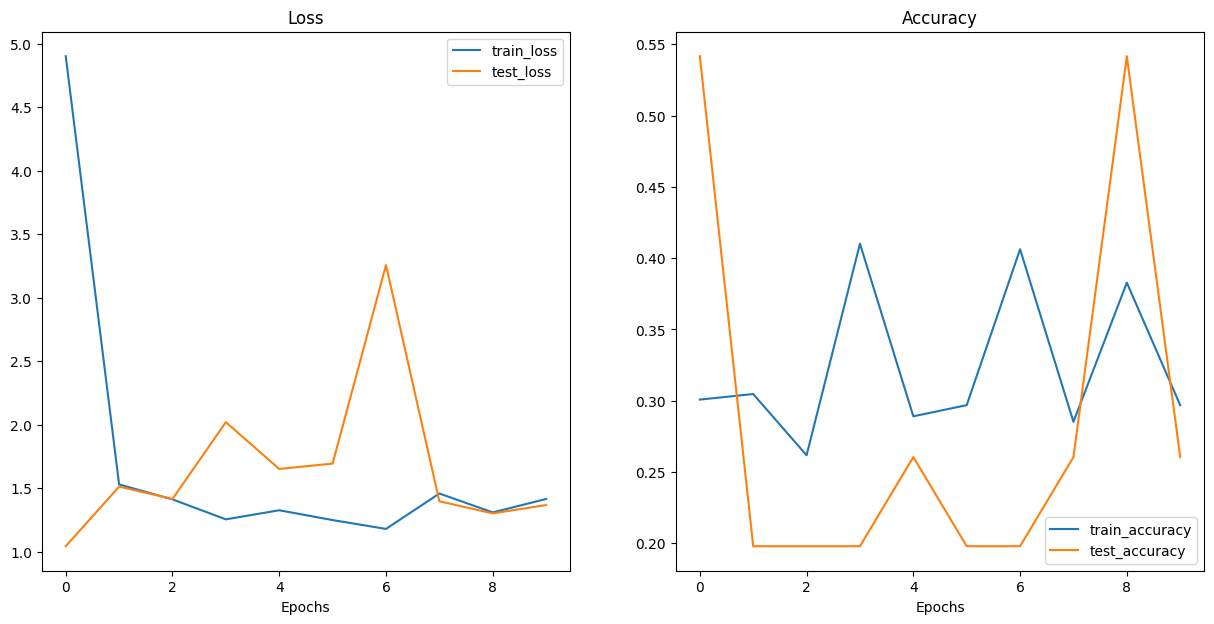

In [75]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretrained ViT from `torchvision.models`

In [76]:
cost = 30 * 24 * 8
print(f"Cost of renting a TPUv3 for 30 straight days: ${cost} USD")

Cost of renting a TPUv3 for 30 straight days: $5760 USD


In [77]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.8.0+cu126
0.23.0+cu126


In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor)

In [79]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
# pretrained_vit_weights

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# pretrained_vit

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 177MB/s]


In [80]:
from torchinfo import summary

summary(
    model=pretrained_vit,
    input_size=(1, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Prepraring data for the pretrained ViT model

In [81]:
# Get automatic transform from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [82]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [83]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

train_dataloader_pretrained, test_dataloader_pretrained, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7855ec003470>,
 ['pizza', 'steak', 'sushi'])

### 10.4 Train feature extractor ViT model

In [84]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                train_dataloader=train_dataloader_pretrained, test_dataloader=test_dataloader_pretrained,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

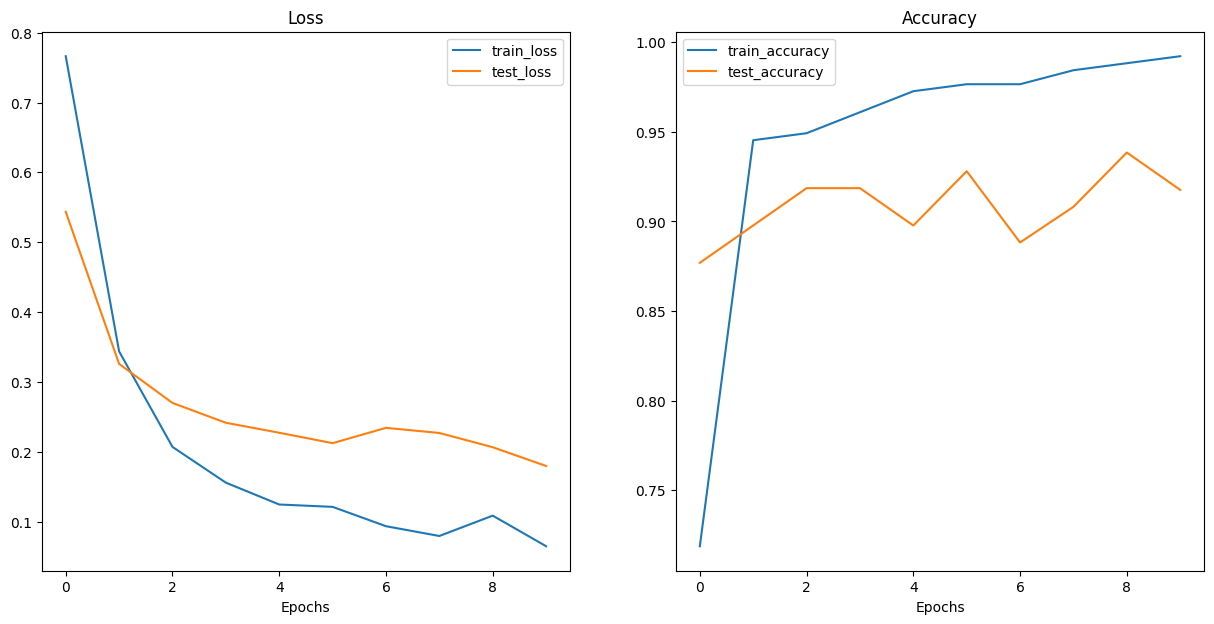

In [85]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing ViT model

In [86]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [87]:
from pathlib import Path

pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## 11. Predicting on custom image

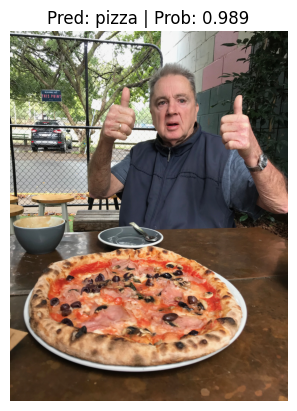

In [88]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [89]:
pretrained_vit_results

{'train_loss': [0.7663078363984823,
  0.3435757923871279,
  0.2068282668478787,
  0.15565912378951907,
  0.12437295215204358,
  0.12098945211619139,
  0.09329074702691287,
  0.07929671768215485,
  0.10844357358291745,
  0.06463209487264976],
 'train_acc': [0.71875,
  0.9453125,
  0.94921875,
  0.9609375,
  0.97265625,
  0.9765625,
  0.9765625,
  0.984375,
  0.98828125,
  0.9921875],
 'test_loss': [0.5435075958569845,
  0.32568230231602985,
  0.26981403927008313,
  0.24144024650255838,
  0.2271267275015513,
  0.2122170478105545,
  0.23415888845920563,
  0.2268028830488523,
  0.20640288293361664,
  0.17953965067863464],
 'test_acc': [0.8768939393939394,
  0.8977272727272728,
  0.9185606060606061,
  0.9185606060606061,
  0.8977272727272728,
  0.9280303030303031,
  0.8882575757575758,
  0.9081439393939394,
  0.9384469696969697,
  0.9176136363636364]}

In [90]:
history = {
    'train_loss': [0.7663, 0.3435, 0.2068, 0.1556, 0.1243, 0.1209, 0.0932, 0.0792, 0.1084, 0.0646],
    'train_acc': [0.7187, 0.9453, 0.9492, 0.9609, 0.9726, 0.9765, 0.9765, 0.9843, 0.9882, 0.9921],
    'test_loss': [0.5435, 0.3256, 0.2698, 0.2414, 0.2271, 0.2122, 0.2341, 0.2268, 0.2064, 0.1795],
    'test_acc': [0.8768, 0.8977, 0.9185, 0.9185, 0.8977, 0.9280, 0.8882, 0.9081, 0.9384, 0.9176]
}

final_train_acc = history['train_acc'][-1] * 100
final_test_acc = history['test_acc'][-1] * 100

print(f'Final Training Accuracy: {final_train_acc:.2f}%')
print(f'Final Testing Accuracy: {final_test_acc:.2f}%')


Final Training Accuracy: 99.21%
Final Testing Accuracy: 91.76%


# Replicating Vision Transformer (ViT) in PyTorch

This notebook replicates the Vision Transformer (ViT) as described in the paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" using PyTorch.

The notebook covers the following steps:

1.  **Setup**: Setting up the environment and downloading the necessary data (pizza, steak, sushi images).
2.  **Data Preparation**: Creating PyTorch Datasets and DataLoaders for the image data.
3.  **ViT Architecture Replication**: Step-by-step implementation of the core components of the ViT model:
    *   Patch Embedding: Converting images into sequences of patches and embedding them.
    *   Class Token and Position Embedding: Adding special tokens and positional information to the patch embeddings.
    *   Multihead Self-Attention (MSA) Block: Implementing the self-attention mechanism.
    *   Multilayer Perceptron (MLP) Block: Implementing the feed-forward network.
    *   Transformer Encoder: Combining MSA and MLP blocks to form the Transformer Encoder layer.
4.  **Building the ViT Model**: Assembling the custom ViT model using the implemented components.
5.  **Training Setup**: Setting up the optimizer and loss function for training the custom ViT model.
6.  **Training Custom ViT**: Training the custom ViT model on the prepared dataset.
7.  **Pretrained ViT**: Utilizing a pretrained ViT model from `torchvision.models` as a feature extractor.
8.  **Data Preparation for Pretrained ViT**: Preparing the data with appropriate transforms for the pretrained ViT.
9.  **Training Pretrained ViT**: Training the pretrained ViT feature extractor model.
10. **Saving the Model**: Saving the best performing pretrained ViT model.
11. **Custom Image Prediction**: Making predictions on a custom image using the trained pretrained ViT model.

This notebook serves as a practical guide to understanding and implementing the Vision Transformer for image classification tasks.